In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb
#!pip install --upgrade folium

In [2]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import folium
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import math
from IPython.display import HTML

## Connexion à la base

In [3]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [4]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [5]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2000 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "KRICHA2"

In [6]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  KLENTZ
Mot de passe :  ········


In [7]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 25


# Présentation générale de l'édition des JO qui vous a été assignée

In [8]:
# recupérer les années des éditions précédentes
anneeJOprecedent = requete_vers_dataframe(conn, f"""SELECT ANNEEHOTE FROM {SCHEMA}.HOTE
WHERE CODENOCHOTE = 'AUS' AND ANNEEHOTE < (SELECT ANNEEHOTE FROM HOTE
                                            WHERE idhote =  {id_hote})""")
# recuperer la ville hote l'édition
df_villeHote = requete_vers_dataframe(conn, f"""SELECT VILLEHOTE FROM {SCHEMA}.HOTE WHERE idhote =  {id_hote}""")
# recuperer l'année de l'édtition
df_anneeHote = requete_vers_dataframe(conn, f"""SELECT ANNEEHOTE FROM {SCHEMA}.HOTE WHERE idhote =  {id_hote}""")
# recupérer les dates des Jeux Olympique 
dateCompetition = requete_vers_dataframe(conn, f"""SELECT DATESCOMPETITION FROM HOTE WHERE IDHOTE = {id_hote}""")
# recupérer les pays hote
df_paysHote = requete_vers_dataframe(conn, f"""SELECT NOMNOC, CODENOC FROM {SCHEMA}.HOTE H INNER JOIN {SCHEMA}.NOC N ON N.CODENOC = H.CODENOCHOTE WHERE idHote = {id_hote}""")
# dates_competition est un tableau, donc boucle pour recupere valeur
for dates in dateCompetition['DATESCOMPETITION'].values:
    # séparer en deux date au '-'
    dateDebut, dateFin = dates.split(' – ')
# calculer du nombre d'éditions précèdentes
ancienJo = anneeJOprecedent['ANNEEHOTE'].values
match len(ancienJo):
    case 0:
        niemeEdition = "première"
    case 1:
        niemeEdition = "deuxième"
    case 2:
        niemeEdition = "troisième"
    case 3:
        niemeEdition = "quatrième"
# stocker résultat dans variable pour l'affichage
villeHote = df_villeHote.loc[0,'VILLEHOTE']
anneeHote = df_anneeHote.loc[0,'ANNEEHOTE']
paysHote = df_paysHote.loc[0,'NOMNOC']
#villeHote_bf = df_villeHote_bf.loc[0,'VILLEHOTE']
anneHote_bf = int(ancienJo)
# recupérer la ville hote de l'édition précédente
NOCHote = df_paysHote.loc[0,'CODENOC']
df_villeHote = requete_vers_dataframe(conn, f"""SELECT VILLEHOTE FROM {SCHEMA}.HOTE H WHERE ANNEEHOTE = {anneHote_bf} AND CODENOCHOTE = '{NOCHote}'""")
villeHote_bf = df_villeHote.loc[0,'VILLEHOTE']

In [9]:
# texte de présentation des Jeux Olympique
display(HTML(f"""Les {EDITION_JO} se sont déroulé principalement à {villeHote}. Ces Jeux ont eu lieu du {dateDebut} au 
            {dateFin} {anneeHote}."""))
display(HTML(f"""Pour l'{paysHote}, c'est la {niemeEdition} fois qu'elle accueillait les Jeux Olympiques, l'édition précédente ayant 
            eu lieu à {villeHote_bf} en {anneHote_bf}"""))

### Récupérer les coordonnées des lieux et les mettres sur une carte

In [10]:
# coordonnées de la ville hote
sydney_coords = [-33.8688, 151.2093]
# Créer une carte centrée sur l'australie 
australia_map = folium.Map(location=sydney_coords, zoom_start=5, width=1200, height=250)

# Ajouter un marqueur pour Sydney
folium.Marker(location=sydney_coords, popup='Sydney').add_to(australia_map)
# Définir l'URL pour les épreuves olympiques
url = 'https://www.olympedia.org/venues/editions/25'

# Récupérer le contenu de la page
request = requests.get(url)    
# récupérer le code HTML de la page
codeHTML = BeautifulSoup(request.text, 'html')  
# rechercher la table contenant les épreuve
codeHTML = codeHTML.find('table', class_='table table-striped')   
# ne garder que les lignes contenant un lien vers un lieu
table = codeHTML.find_all('a', href=lambda href: href and '/venues/7' in href)    
# Extraire le href et le nom du lieu
table = [{'href': lien['href'], 'nom': lien.text} for lien in table]

# placer marqueur pour chaque épreuve sur la carte de l'australie
url_lieu = "https://www.olympedia.org"
marker_table = []
for lien in table :
    # lien de la page de l'épreuve
    url_lieu_modif = url_lieu + lien['href']
    # récupere le contenu de la page
    request = requests.get(url_lieu_modif)    
    # récuperer le code HTML de la page
    codeHTML = BeautifulSoup(request.text, 'html')
    # rechercher les lignes contenant les coordonnées de l'épreuve
    coordonnee = codeHTML.find(string=re.compile("(Definitely here)"))
    pattern = r'(-?\d+\.\d+),\s*(-?\d+\.\d+)'
    matches = re.search(pattern, coordonnee)
    # extraire la lattitude et la longitude
    latitude = matches.group(1)
    longitude = matches.group(2)
    coords = [latitude, longitude]
    # ajouter un point sur la carte avec les coordonnées de l'épreuve
    folium.Marker(location=coords).add_to(australia_map)
# afficher la carte des épreuves 
display(HTML(f"<b><font size='+2'>Carte des épreuves des Jeux Olympique d'été 2000</font></b>"))
print(" ")
display(australia_map)

In [11]:
# afficher les épreuves présente à ces Jeux Olympique
epreuveJO = requete_vers_dataframe(conn, f"""SELECT DISTINCT nomDiscipline FROM {SCHEMA}.DISCIPLINE
NATURAL JOIN {SCHEMA}.EVENEMENT WHERE idHote = {id_hote}""")
display(HTML(f"<b><font size='+2'>Épreuves présente au {EDITION_JO}</font></b>"))
display(epreuveJO)

,NOMDISCIPLINE
0,Athletics
1,Baseball
2,Boxing
3,Tennis
4,Basketball
5,Canoe Sprint
6,Cycling Track
7,Equestrian Dressage
8,Modern Pentathlon
9,Swimming


In [12]:
# sport présent à cette édition
sportJo = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomSport FROM SPORT
NATURAL JOIN DISCIPLINE
NATURAL JOIN EVENEMENT
WHERE IDHOTE = {id_hote}""")
display(HTML(f"<b><font size='+2'>Sport présent au {EDITION_JO}</font></b>"))
display(sportJo)

,NOMSPORT
0,Athletics
1,Boxing
2,Tennis
3,Wrestling
4,Basketball
5,Volleyball
6,Triathlon
7,Modern Pentathlon
8,Judo
9,Cycling


In [13]:
# Calculer avec une requête et afficher les épreuves nouvellement ajoutée à cette édition
nvlleEpreuve  = requete_vers_dataframe(conn, f"""SELECT DISTINCT nomDiscipline FROM {SCHEMA}.DISCIPLINE
NATURAL JOIN {SCHEMA}.EVENEMENT
WHERE idHote = {id_hote} AND nomDiscipline NOT IN (SELECT nomDiscipline FROM {SCHEMA}.DISCIPLINE
                                            NATURAL JOIN {SCHEMA}.EVENEMENT
                                            WHERE idHote = {id_hote}-1)""")

display(HTML(f"<b><font size='+2'>Épreuves nouvellement ajoutées à cette édition</font></b>"))
display(nvlleEpreuve)

,NOMDISCIPLINE
0,Triathlon
1,Trampolining
2,Taekwondo


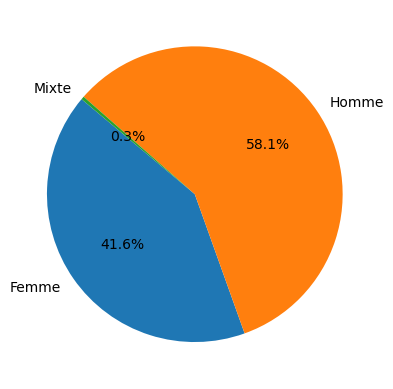

In [14]:
# Initialisation du DataFrame pour la répartition des épreuves par genre
repartitionEpreuve =[]
# Nombre d'épreuves femme
epreuveFemme = requete_vers_dataframe(conn, f"""SELECT COUNT(*) FROM {SCHEMA}.EVENEMENT
                                              WHERE NOMEVENEMENT LIKE '%Women%' AND idHote = {id_hote} """)
repartitionEpreuve.append({'TYPE': 'Femme', 'TOTAL': epreuveFemme.iloc[0, 0]})
# Nombre d'épreuves homme
epreuveHomme = requete_vers_dataframe(conn, f"""SELECT COUNT(*) FROM {SCHEMA}.EVENEMENT
                                              WHERE NOMEVENEMENT LIKE '%Men%' AND idHote = {id_hote} """)
repartitionEpreuve.append({'TYPE': 'Homme', 'TOTAL': epreuveHomme.iloc[0, 0]})
# Nombre d'épreuves mixte
epreuveMixte = requete_vers_dataframe(conn, f"""SELECT COUNT(*) FROM {SCHEMA}.EVENEMENT
                                              WHERE NOMEVENEMENT LIKE '%Mixed%' AND idHote = {id_hote} """)
repartitionEpreuve.append({'TYPE': 'Mixte', 'TOTAL': epreuveMixte.iloc[0, 0]})
# tableau vers dataframe pour l'affichage 
df_repartitionEpreuve = pd.DataFrame(repartitionEpreuve)
# Affichage des résultats
display(HTML(f"<b><font size='+2'>Répartition des épreuves par genre lors des {EDITION_JO}</font></b>"))
# Diagramme circulaire 
plt.pie(df_repartitionEpreuve['TOTAL'], labels=df_repartitionEpreuve['TYPE'], autopct='%1.1f%%', startangle=140)
plt.show()

In [15]:
# recupere les idHote de tout les Jeux Olympique d'été qui n'ont pas été annulés
hoteSummer  = requete_vers_dataframe(conn, f"""SELECT idHote, anneeHote FROM {SCHEMA}.HOTE
WHERE Saison ='Summer' AND DATESCOMPETITION != '—'""")

In [16]:
# Calculer avec une requête et afficher le nombre d'épreuve de chaque genre 
resultats = []
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour afficher les épreuves femmes
    genreEpreuveWomen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Women%'""")
    # requete pour afficher les épreuves hommes
    genreEpreuveMen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Men%'""")
    # calculer le nombre d'épreuve de chaque genre
    nbWomen = genreEpreuveWomen['NOMDISCIPLINE'].count()
    nbMen = genreEpreuveMen['NOMDISCIPLINE'].count()
    # Ajouter les résultats au dictionnaire résultat
    resultats.append({'ANNEEHOTE': anneeHote, 'NBMEN': nbMen, 'NBWOMEN': nbWomen})

# transformer le dictionnarie en dataframe pour l'affichage
df_resultats = pd.DataFrame(resultats)

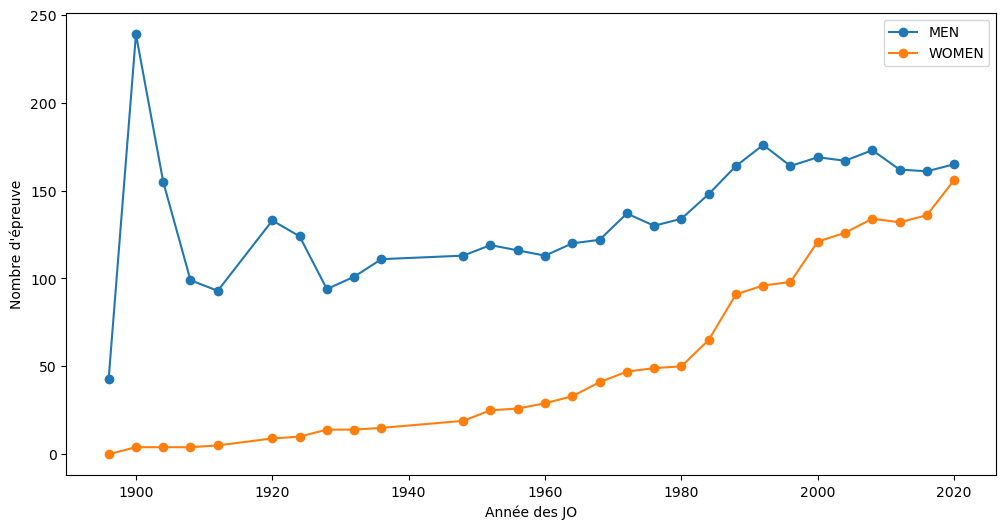

In [17]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  
# Tracer MEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBMEN'], marker='o', linestyle='-', label='MEN')
# Tracer WOMEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBWOMEN'], marker='o', linestyle='-', label='WOMEN')

# Ajouter des légendes et titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuve par genre</font></b>"))
print(" ")
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'épreuve")
display(plt.legend())

Interpréter et/ou expliquer ce qui est présenté : On remarque qu'il y a de plus en plus d'épreuve féminine au Jeux Olympique. Il y a également chez les femmes et les hommes de plus en plus d'épreuve chaque années.

# Comparaison de cette édition avec les éditions qui l'ont précédée

### classement des nations (tableau de classement pour les trois couleurs de médailles et pour le total) + répartition des médailles par couleur et par pays.

In [18]:
# requete pour recuperer le classement NOC médailles
classementNocEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
WHERE IDHOTE = '{id_hote}'
GROUP BY EQ.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, eq.noc""")
# requete pour recuperer le classement NOC individuel
classementNocIndividuel = requete_vers_dataframe(conn,f"""SELECT PI.NOC,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
GROUP BY PI.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, noc""")

In [19]:
display(HTML(f"<b><font size='+2'>Classement des nations par médailles durant les {EDITION_JO}</font></b>"))
print(" ")

# création d'un classement global avec les médailles collectives et individuelle
clasementNocGlobal = pd.merge(classementNocEquipe, classementNocIndividuel, on='NOC')
# fusion des colones pour aditionner les médaillles
clasementNocGlobal['GOLD'] = clasementNocGlobal['GOLD_x'] + clasementNocGlobal['GOLD_y']
clasementNocGlobal['SILVER'] = clasementNocGlobal['SILVER_x'] + clasementNocGlobal['SILVER_y']
clasementNocGlobal['BRONZE'] = clasementNocGlobal['BRONZE_x'] + clasementNocGlobal['BRONZE_y']
clasementNocGlobal['TOTAL'] = clasementNocGlobal['TOTAL_x'] + clasementNocGlobal['TOTAL_y']
# trier le dataframe par le total de médailles
clasementNocGlobal = clasementNocGlobal[['NOC', 'GOLD', 'SILVER', 'BRONZE', 'TOTAL']].sort_values(by=['TOTAL'], ascending=False)
# afficher le dataframe
display(clasementNocGlobal)

,NOC,GOLD,SILVER,BRONZE,TOTAL
0,USA,37,24,32,93
3,RUS,32,28,29,89
4,CHN,28,16,14,58
1,AUS,16,25,17,58
2,GER,13,17,26,56
...,...,...,...,...,...
67,LUX,0,0,0,0
68,MAD,0,0,0,0
70,MAS,0,0,0,0
72,MRI,0,0,0,0


Interpréter et/ou expliquer ce qui est présenté : l'Australie à réaliser son meilleur résultat, surement car les Jeux Olympique 2000 se déroulait à Sydney. 

### répartition des médailles par genre et par pays, comparaison à l'aide de la moyenne/écart-type et min/max/quartiles/médiane.

In [20]:
def calculeMoyenne(serie): 
    nb = 0
    n = 0
    for index, row in serie.iterrows():
        n+= row['NBATHLETE']
        nb += row['NBATHLETE']*row['NBMEDAILLE']
    if n==0:
        return 0
    return nb/n

def calculeEcartType(serie): 
    nb = 0
    n = 0
    for index, row in serie.iterrows():
        n+= row['NBATHLETE']
        nb += row['NBATHLETE']*(row['NBMEDAILLE'])**2
    if n==0:
        return 0
    variance =  nb/n
    return math.sqrt(variance)

def minSerie(serie):
    minVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] < minVal or first:
            minVal = row['NBMEDAILLE']
            first = False
    return minVal

def maxSerie(serie):
    maxVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] > maxVal or first:
            maxVal = row['NBMEDAILLE']
            first = False
    return maxVal

def quartilsSerie(serie):
    quartils = list()
    frequence_relative_cumulee = 0
    taille_echantillon = serie['NBATHLETE'].sum()
    if taille_echantillon == 0:
        return[0,0,0]
    for index,row in serie.iterrows(): 
        frequence_relative_cumulee += (row['NBATHLETE']/taille_echantillon)
        if (frequence_relative_cumulee>=0.25):
            quartils.append(row['NBMEDAILLE'])
        if (frequence_relative_cumulee>=0.50):
            quartils.append(row['NBMEDAILLE'])
        if (frequence_relative_cumulee>=0.75):
            quartils.append(row['NBMEDAILLE'])
    return quartils

def nbMedaille(serie):
    somme = 0
    for index,row in serie.iterrows(): 
        somme += row["NBMEDAILLE"]*row["NBATHLETE"]
    return somme

In [ ]:
#Tableau Statistique répartions par genre : nb de médailles par athelte en moyenne + ecart type etc...

saison = requete_vers_dataframe(conn, "SELECT distinct anneehote FROM hote WHERE saison = 'Summer' and anneeHote < 2000 ORDER BY anneehote")

moyennes = list()
ecarts = list()
min = list()
max = list()

serie_hommes  = requete_vers_dataframe(conn, f"""SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                FROM {SCHEMA}.medailles_athletes_2000 ma
                                                INNER JOIN {SCHEMA}.athlete a ON a.idathlete = ma.idathlete
                                                WHERE genre = 'Male'
                                                GROUP BY total
                                                ORDER BY total
                                           """)

serie_femmes  = requete_vers_dataframe(conn, f"""SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                    FROM {SCHEMA}.medailles_athletes_2000 ma
                                                    INNER JOIN {SCHEMA}.athlete a ON a.idathlete = ma.idathlete
                                                    WHERE genre = 'Female'
                                                    GROUP BY total
                                                    ORDER BY total
                                           """)


moyennes.append(calculeMoyenne(serie_hommes))
moyennes.append(calculeMoyenne(serie_femmes))

ecarts.append(calculeEcartType(serie_hommes))
ecarts.append(calculeEcartType(serie_femmes))

quartil_hommes = quartilsSerie(serie_hommes)
quartil_femmes = quartilsSerie(serie_femmes)

min.append(minSerie(serie_hommes))
min.append(minSerie(serie_femmes))

max.append(maxSerie(serie_hommes))
max.append(maxSerie(serie_femmes))

nb_medaille_homme = nbMedaille(serie_hommes)
nb_medaille_femme = nbMedaille(serie_femmes)

statistiques_2000 = {
    'Annee': ['2000', '2000'],
    'Genre': ['Homme', 'Femme'],
    'Moyenne': moyennes,
    'Ecart Type': ecarts,
    '1er quartil': [quartil_hommes[0], quartil_femmes[0]],
    'Médiane': [quartil_hommes[1], quartil_femmes[1]],
    '3e quartil': [quartil_hommes[2], quartil_femmes[2]],
    'Min': min,
    'Max': max,
    'TotalMedaille' : [nb_medaille_homme, nb_medaille_femme]
}

statistiques_2000 = pd.DataFrame(statistiques_2000)

display(HTML(f"<b><font size='+2'>Différence Homme/Femme pendant {EDITION_JO}</font></b>"))
display(statistiques_2000)

statistiques_avant_2000 = pd.DataFrame({
    'Annee':[],
    'Genre': [],
    'Moyenne': [],
    'Ecart Type': [],
    '1er quartil': [],
    'Médiane': [],
    '3e quartil': [],
    'Min': [],
    'Max': [],
    'TotalMedaille': []
})

display(statistiques_avant_2000)

for i, row in saison.iterrows():
    serie_homme_saison = requete_vers_dataframe(conn, f"""
                                                        SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                        FROM (SELECT idathlete,
                                                        COUNT(medaille) AS total
                                                        FROM 
                                                        (SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM {SCHEMA}.athlete a
                                                        LEFT JOIN {SCHEMA}.participation_individuelle pi ON a.idAthlete = pi.idAthlete
                                                        INNER JOIN {SCHEMA}.evenement e ON e.idevenement = pi.idevent
                                                        INNER JOIN {SCHEMA}.hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Male' AND saison = 'Summer' AND  anneeHote = {row['ANNEEHOTE']}
                                                        UNION ALL
                                                        SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM {SCHEMA}.athlete a
                                                        LEFT JOIN {SCHEMA}.composition_equipe ce ON a.idAthlete = ce.idAthlete
                                                        INNER JOIN {SCHEMA}.participation_equipe pe ON pe.idequipe = ce.idequipe
                                                        INNER JOIN {SCHEMA}.evenement e ON e.idevenement = pe.idevenement
                                                        INNER JOIN {SCHEMA}.hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Male' AND saison = 'Summer' AND anneeHote = {row['ANNEEHOTE']})
                                                        GROUP BY idathlete, nomathlete, prenomathlete)
                                                        GROUP BY total
                                                        ORDER BY total
                                                        """)
    
    ecart = quartilsSerie(serie_homme_saison)

    rang = {
        'Annee': row['ANNEEHOTE'],
        'Genre': 'Homme',
        'Moyenne': calculeMoyenne(serie_homme_saison),
        'Ecart Type': calculeEcartType(serie_homme_saison),
        '1er quartil': ecart[0],
        'Médiane': ecart[1],
        '3e quartil': ecart[0],
        'Min': minSerie(serie_homme_saison),
        'Max': maxSerie(serie_homme_saison),
        'TotalMedaille': nbMedaille(serie_homme_saison)
    }

    rang_df = pd.DataFrame([rang])

    # Utiliser pd.concat pour ajouter la nouvelle ligne
    statistiques_avant_2000 = pd.concat([statistiques_avant_2000, rang_df], ignore_index=True)
    
    serie_femme_saison = requete_vers_dataframe(conn, f"""
                                                        SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                        FROM (SELECT idathlete,
                                                        COUNT(medaille) AS total
                                                        FROM 
                                                        (SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM {SCHEMA}.athlete a
                                                        LEFT JOIN {SCHEMA}.participation_individuelle pi ON a.idAthlete = pi.idAthlete
                                                        INNER JOIN {SCHEMA}.evenement e ON e.idevenement = pi.idevent
                                                        INNER JOIN {SCHEMA}.hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Female' AND saison = 'Summer' AND  anneeHote = {row['ANNEEHOTE']}
                                                        UNION ALL
                                                        SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM {SCHEMA}.athlete a
                                                        LEFT JOIN {SCHEMA}.composition_equipe ce ON a.idAthlete = ce.idAthlete
                                                        INNER JOIN {SCHEMA}.participation_equipe pe ON pe.idequipe = ce.idequipe
                                                        INNER JOIN {SCHEMA}.evenement e ON e.idevenement = pe.idevenement
                                                        INNER JOIN {SCHEMA}.hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Female' AND saison = 'Summer' AND anneeHote = {row['ANNEEHOTE']})
                                                        GROUP BY idathlete, nomathlete, prenomathlete)
                                                        GROUP BY total
                                                        ORDER BY total
                                                        """)
    
    ecart = quartilsSerie(serie_femme_saison)

    rang = {
        'Annee': int(row['ANNEEHOTE']),
        'Genre': 'Femme',
        'Moyenne': calculeMoyenne(serie_femme_saison),
        'Ecart Type': calculeEcartType(serie_femme_saison),
        '1er quartil': ecart[0],
        'Médiane': ecart[1],
        '3e quartil': ecart[0],
        'Min': minSerie(serie_femme_saison),
        'Max': maxSerie(serie_femme_saison),
        'TotalMedaille': nbMedaille(serie_femme_saison)
    }

    rang_df = pd.DataFrame([rang])

    # Utiliser pd.concat pour ajouter la nouvelle ligne
    statistiques_avant_2000 = pd.concat([statistiques_avant_2000, rang_df], ignore_index=True)

moyennes_avant_2000 = list()
ecarts_avant_2000 = list()
min_avant_2000 = list()
max_avant_2000 = list()

display(statistiques_avant_2000)

,Annee,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille
0,2000,Homme,0.170006,0.450113,0,0,0,0,6,1137
1,2000,Femme,0.218388,0.522884,0,0,0,0,5,905


,Annee,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille


### Répartion du nombre de médaille gagnées par genre

In [ ]:
# Grille pour les afficher l'un à coté de l'autre (1 ligne, 2 colonnes)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(statistiques_2000['TotalMedaille'],labels=['Homme', 'Femme'], startangle=90)
ax1.set_title('Pendant 2000 Summer Olympics')

repartition = [0,0]
for i, row in statistiques_avant_2000.iterrows():
    if row['Genre'] == 'Homme':
        repartition[0] += row['TotalMedaille']
    else:
        repartition[1] += row['TotalMedaille']

ax2.pie(repartition, labels=['Homme', 'Femme'],startangle=90)
ax2.set_title('Avant 2000')

# Ajustement de la disposition pour éviter les chevauchements
plt.tight_layout()

plt.show()

### Moyenne et écart type du nombre de médaille gagné par genre

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

stats_avant_2000_groupe = statistiques_avant_2000.groupby('Genre')
stats_avant_2000_groupe = stats_avant_2000_groupe.agg({
    'Moyenne': 'mean',
    'Ecart Type': 'mean',
    '1er quartil': 'mean',
    'Médiane': 'mean',
    '3e quartil': 'mean',
    'Min': 'min',
    'Max': 'max',
    'TotalMedaille': 'sum'
}).reset_index()

display(stats_avant_2000_groupe)

x_pos = range(len(statistiques_2000['Genre']))
axs[0].bar(x_pos, statistiques_2000['Moyenne'], yerr=statistiques_2000['Ecart Type'], align='center', capsize=10)
axs[0].set_xlabel('Genre')
axs[0].set_ylabel('Moyenne')
axs[0].set_title('Moyenne et écart-type par genre \npendant 2000 Summer Olympics')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(statistiques_2000['Genre'])
axs[0].yaxis.grid(True)

x_pos = range(len(stats_avant_2000_groupe['Genre']))
axs[1].bar(x_pos, stats_avant_2000_groupe['Moyenne'], yerr=stats_avant_2000_groupe['Ecart Type'], align='center', capsize=10)
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Moyenne')
axs[1].set_title('Moyenne et écart-type par genre avant 2000')
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(stats_avant_2000_groupe['Genre'])
axs[1].yaxis.grid(True)

# Affichage du graphique
plt.tight_layout()
plt.show()

On remarque que le premier quartil, la médianne et le 3e quartils sont égals à 0. Ils sont égals à 0 car obtenir une médailles aux Jeux Olympiques est très rare, ainsi, le nombre de personne sans médaille est largement plus grand (>75%) que le nombre de personne à en avoir obtenus.
Étant donné que ces indicateurs sont à 0, cela n'est pas pertinents de les afficher sur un graphique.

### Répartion des médailles gagnées par pays

In [ ]:
def calculerMoyenneMedailleNoc(serie):
    somme = 0
    nbNoc = 0
    for i, row in serie.iterrows():
        somme += row['NBMEDAILLE']
        nbNoc += 1
    if nbNoc == 0:
        return 0
    return somme/nbNoc

def calculerEcartTypeMedailleNoc(serie):
    somme = 0
    nbNoc = 0
    for i, row in serie.iterrows():
        somme += row['NBMEDAILLE']^2
        nbNoc += 1
    if nbNoc == 0:
        return 0
    return math.sqrt(somme/nbNoc)

def minSerieNoc(serie):
    minVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] < minVal or first:
            minVal = row['NBMEDAILLE']
            first = False
    return minVal

def maxSerieNoc(serie):
    maxVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] > maxVal or first:
            maxVal = row['NBMEDAILLE']
            first = False
    return maxVal

def quartilsSerieNoc(serie):
    quartils = list()
    nb_element = serie["NBMEDAILLE"].count()
    if(nb_element%4 == 0):
        quartils.append(serie["NBMEDAILLE"][(nb_element//4)-1])
        quartils.append((serie["NBMEDAILLE"][(nb_element//2)-1]+serie["NBMEDAILLE"][(nb_element/2)-1])/2)
        quartils.append(serie["NBMEDAILLE"][(3*nb_element//4)-1])
    else:
        quartils.append(serie["NBMEDAILLE"][(nb_element//4)])
        quartils.append(serie["NBMEDAILLE"][(nb_element//2)])
        quartils.append(serie["NBMEDAILLE"][(3*nb_element//4)])
    return quartils

In [ ]:
serie_noc_2000 = requete_vers_dataframe(conn, f"""
                                        SELECT * FROM {SCHEMA}.medailles_noc_athletes
                                        """)

serie_noc_avant_2000 = requete_vers_dataframe(conn, f"""
                                        SELECT * FROM {SCHEMA}.medailles_noc_athletes_avant_2000
                                        """)

quartil_2000 = quartilsSerieNoc(serie_noc_2000)

quartil_avant_2000 = quartilsSerieNoc(serie_noc_avant_2000)

statistiques_global_nocs = {
    'Édition' : ['2000 Summer Olympics', 'Moyenne des éditions avant 2000'],
    'Moyenne': [calculerMoyenneMedailleNoc(serie_noc_2000), calculerMoyenneMedailleNoc(serie_noc_avant_2000)],
    'Ecart-Type': [calculerEcartTypeMedailleNoc(serie_noc_2000), calculerMoyenneMedailleNoc(serie_noc_avant_2000)],
    '1er quartil': [quartil_2000[0],quartil_avant_2000[0]],
    'Médianne': [quartil_2000[1],quartil_avant_2000[1]],
    '3e quartil': [quartil_2000[2],quartil_avant_2000[2]],
    'Min': [minSerieNoc(serie_noc_2000),minSerieNoc(serie_noc_avant_2000)],
    'Max': [maxSerieNoc(serie_noc_2000),maxSerieNoc(serie_noc_avant_2000)],
}

statistiques_global_nocs = pd.DataFrame(statistiques_global_nocs)

display(statistiques_global_nocs)

Interpréter et/ou expliquer ce qui est présenté : On remarque une légère hausse du nombre de médaille moyen lors des jeux de 2000. C'est probablement du à un haut du tableau qui remonte cette moyenne car la médianne est quand meme plus faible que lors des éditions précédentes. On remarque que le nombre maximale de médaille est lui aussi plus élévé en 2000 : 253 médaille, pour les éditions précédentes, en moyenne le nombre max de médaille est de 234.

### répartition des médailles par continent (Amérique, Europe, Asie, Afrique, Océanie), comparaison là aussi avec les outils vus en statistiques. [Bonus]

In [ ]:
# Créer une nouvelle table continent

Interpréter et/ou expliquer ce qui est présenté : 

### autres idées de répartitions pertinentes [Bonus]

Interpréter et/ou expliquer ce qui est présenté : 

### évolution de ces classements par rapport à l'édition précédente [Bonus]

In [ ]:
### évolution à long terme pour le top 3 de cette édition (c'est-à-dire que pour les trois meilleurs pays de cette édition, on veut savoir quelle était leur performance sur les jeux de même type (jeux d'été ou jeux d'hiver) lors des éditions qui ont précédé).

# récupere les idHote des 3 pays avec le plus de médailles
idTop3 = [clasementNocGlobal['NOC'].loc[i] for i in range(3)]
# initialisation d'un dataframe 
resultats_top3 = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC', 'TOTAL'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre de médailles par équipe de {noc} durant {idhote}
        ClassementEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
        COUNT(PE.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E 
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
        WHERE IDHOTE = {idHote}
        GROUP BY EQ.NOC
        HAVING EQ.NOC = '{noc}'""")
        # requete pour recupérer le nombre de médailles en individuelle de {noc} durant {idhote}
        ClassementIndividuelle = requete_vers_dataframe(conn,f"""SELECT idAthlete, COUNT(PI.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E
        INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
        WHERE IDHOTE = {idHote} AND NOC = '{noc}'
        GROUP BY idAthlete""")
        # assigner l'idHote et l'annéeHote à la ligne pour concatener
        ClassementEquipe['IDHOTE'] = idHote
        ClassementEquipe['ANNEEHOTE'] = anneeHote
        # ajouter le total des médailles individuelles au total des médailles en équipe pour avoir le nombre de médaille total
        ClassementEquipe['TOTAL'] += ClassementIndividuelle['TOTAL'].sum()
        # ajouter la ligne dans un dataframe
        resultats_top3 = pd.concat([resultats_top3, ClassementEquipe], ignore_index=True)

In [ ]:
# créer un dataframe pour chaque nation pour afficher les statistique
resultats_top3USA = resultats_top3[resultats_top3['NOC'] == 'USA']
resultats_top3GER = resultats_top3[resultats_top3['NOC'] == 'GER']
resultats_top3AUS = resultats_top3[resultats_top3['NOC'] == 'AUS']

# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(resultats_top3USA.ANNEEHOTE, resultats_top3USA['TOTAL'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(resultats_top3GER.ANNEEHOTE, resultats_top3GER['TOTAL'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(resultats_top3AUS.ANNEEHOTE, resultats_top3AUS['TOTAL'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel('Nombre de médaille')
display(HTML(f"<b><font size='+2'>Évolution du nombre de médaille par nation </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On remarque que l'Allemagne n'a pas gagné de médaille entre 1970 et 1980, car le pays était divisée en deux délégations (RDA et RFA). Depuis, l'Allemagne remporte de moins en moins de médaille, car les autres pays deviennent de plus en plus fort, et le pays doit se restructurer après la réunification, donc investis moins dans le sport.

### tailles des délégations (et tendances à long terme). [Bonus]

In [ ]:
## J'AI PAS FAIT LES TENDANCES A LONG TERME
# initialisation d'un dataframe
taille_deleg = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre d'athlete
        nbAthleteNoc = requete_vers_dataframe(conn, f"""SELECT COUNT(DISTINCT idAthlete) FROM (
        SELECT PI.idAthlete FROM {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote ={idHote} AND PI.NOC = '{noc}'
        UNION ALL
        SELECT CE.idAthlete FROM {SCHEMA}.COMPOSITION_EQUIPE CE
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON EQ.idEquipe = PE.idEquipe
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote = {idHote} AND EQ.NOC = '{noc}')""")
         # assigner l'idHote, l'annéeHote et noc à la ligne pour concatener 
        nbAthleteNoc['IDHOTE'] = idHote
        nbAthleteNoc['ANNEEHOTE'] = anneeHote
        nbAthleteNoc['NOC'] = noc
        # concatener la ligne 
        taille_deleg = pd.concat([taille_deleg, nbAthleteNoc], ignore_index=True)
# renommer la colonnes count pour plus de clarete
taille_deleg = taille_deleg.rename(columns={'COUNT(DISTINCTIDATHLETE)': 'NBATHLETE'})

In [ ]:
# créer un dataframe pour chaque nation pour afficher les statistique
taille_delegUSA = taille_deleg[taille_deleg['NOC'] == 'USA']
taille_delegGER = taille_deleg[taille_deleg['NOC'] == 'GER']
taille_delegAUS = taille_deleg[taille_deleg['NOC'] == 'AUS']
# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(taille_delegUSA.ANNEEHOTE, taille_delegUSA['NBATHLETE'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(taille_delegGER.ANNEEHOTE, taille_delegGER['NBATHLETE'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(taille_delegAUS.ANNEEHOTE, taille_delegAUS['NBATHLETE'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'athlete envoyé")
display(HTML(f"<b><font size='+2'>Évolution du nombre d'athlete envoyé par chaque délégation </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On vois que lors de l'édition de 1980, les États-Unis ont décider de boycotter l'édition se déroulant en URSS, en envoyant aucun athlete. On vois également qu'a partir de 1970 et jusqu'en 1990, l'allemgne n'a envoyé aucun athlete. Cause de la division du pays en deux délégation (RDA et RFA). Depuis, la réunification, la taille de la délégation se stabilise autour de 500 athlete, tout comme l'Australie.

### moyennes d'âge des athlètes (et tendances à long terme).

In [ ]:
# PAS FAIT TENDANCE A LONG TERME
# initialisation de dataFrame
moyenneAgeJOMen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJOWomen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJO = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer l'age moyen des hommes au moment de leurs participations au JO
    ageAthleteMen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Male'""")
    # requete pour récuperer l'age moyen des femmes au moment de leurs participations au JO
    ageAthleteWomen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Female'""")
    # Supprimer les doublons
    ageAthleteWomen = ageAthleteWomen.drop_duplicates(subset='IDATHLETE')
    ageAthleteMen = ageAthleteMen.drop_duplicates(subset='IDATHLETE')
    # calculer l'age moyen
    ageMoyenMen = ageAthleteMen['AGECOMPET'].mean()
    ageMoyenWomen = ageAthleteWomen['AGECOMPET'].mean()
    # concatener (ajouter ligne à un dataFrame)
    moyenneAgeJOMen = pd.concat([moyenneAgeJOMen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenMen]})], ignore_index=True)
    moyenneAgeJOWomen = pd.concat([moyenneAgeJOWomen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenWomen]})], ignore_index=True)

In [ ]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  

# Tracer HOMME
plt.plot(moyenneAgeJOMen.ANNEEHOTE, moyenneAgeJOMen['AGEMOYEN'], marker='o', linestyle='-', label='HOMME')
# Tracer FEMME
plt.plot(moyenneAgeJOWomen.ANNEEHOTE, moyenneAgeJOWomen['AGEMOYEN'], marker='o', linestyle='-', label='FEMME')

# Ajouter des légendes et titre
plt.xlabel('Année des JO')
plt.ylabel('Age moyen')
display(HTML(f"<b><font size='+2'>Évolution de l'age moyen des athlete par genre </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On vois que lors des JO de 1896, une femme de trente ans à participer, alors que les femmes y était interdite. Stamata Revithi est une femme qui as couru le marathon Homme. On vois également que depuis 196., l'age moyen ne cesse d'augmenter, problament due à la profesionnalisation du sport. La ou auparavant les athlete envoyé était amateur.

### tailles des athlètes (et tendances à long terme). [Bonus]

In [ ]:
# requete renvoyant la taille des athletes fessant des sport collectif
tailleMoyenSportCollectifGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe 
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.CodeSport = D.CodeSport""")
# requete renvoyant la taille des athletes fessant des sport individuel 
tailleMoyenSportIndividuelGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.codeSport = D.CodeSport""")

In [ ]:
# calculer la taille moyenne par sport et par genre
taille_moyenneGenreIndividuelle = tailleMoyenSportIndividuelGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
taille_moyenneGenreEquipe = tailleMoyenSportCollectifGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
# trier par taille décroissante
taille_moyenneGenreEquipe = taille_moyenneGenreEquipe.sort_values(by=['TAILLE'], ascending=False)
taille_moyenneGenreIndividuelle = taille_moyenneGenreIndividuelle.sort_values(by=['TAILLE'], ascending=False)

In [ ]:
# Création de la figure
plt.figure(figsize=(14, 15))

# Tracer les barres pour les sports collectifs
for genre in taille_moyenneGenreEquipe['GENRE'].unique():
    df = taille_moyenneGenreEquipe[taille_moyenneGenreEquipe['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Collectif')

# Tracer les barres pour les sports individuels
for genre in taille_moyenneGenreIndividuelle['GENRE'].unique():
    df = taille_moyenneGenreIndividuelle[taille_moyenneGenreIndividuelle['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Individuel')
    
# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Taille Moyenne (cm)')
plt.ylabel('Sport')
display(HTML(f"<b><font size='+2'>Taille Moyenne des Athlètes par Sport et par Genre </font></b>"))
print(" ")
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

Interpréter et/ou expliquer ce qui est présenté : On vois que certain sport comme le polo, le Tug-Of-War ou la pelote basque, était des sport reservé au hommes, donc aucune femmes n'y a jamais participé. On vois également que les sport où les athletes sont les plus grands sont le basketball et le volleyBall, ce qui est cohérent car la taille représente un atout majeur dans ces sport.

### féminisation : nombre d'événements féminins, nombre d'athlètes femme (et tendance à long terme).

In [ ]:
# Initialisation du DataFrame
df_femme = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NBEPREUVEFEMME', 'NBFEMME'])
df_femme[['ANNEEHOTE', 'NBEPREUVEFEMME']] = df_resultats[['ANNEEHOTE', 'NBWOMEN']]

# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeIndividuelle = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete FROM {SCHEMA}.ATHLETE A
        INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
        WHERE E.idHote = {idHote}  AND Genre = 'Female'""")
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeCollective = requete_vers_dataframe(conn, f"""SELECT A.idAthlete FROM {SCHEMA}.ATHLETE A
        INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
        WHERE E.idHote = {idHote} AND Genre = 'Female'""")
    # combiner les deux résultats
    nombreFemme = pd.concat([femmeIndividuelle,femmeCollective]).reset_index(drop=True)
    # suppresion des doublons
    nombreFemme = nombreFemme.drop_duplicates(subset='IDATHLETE')
    nbFemmeCount = nombreFemme.shape[0]
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'NBFEMME'] = nbFemmeCount
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'IDHOTE'] = idHote

In [ ]:
# taille de la figure
plt.figure(figsize=(15, 6))
# initalisation d'un nuage de point avec x: NBEPREUVEFEMME et y : NBFEMME
plt.scatter(df_femme['NBEPREUVEFEMME'], df_femme['NBFEMME'], color='blue', alpha=0.6)
# Ajouter des labels et un titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuves féminines par rapport au nombre de femmes présentes</font></b>"))
print(" ")
plt.xlabel("Nombre d'épreuves féminines")
plt.ylabel("Nombre de femmes présentes")
# affichage des années des JO au déssus des points
for i in range(len(df_femme)):
    plt.annotate(df_femme['ANNEEHOTE'][i], (df_femme['NBEPREUVEFEMME'][i], df_femme['NBFEMME'][i]), textcoords="offset points", xytext=(0,5), ha='center')


# Afficher le nuage de points
plt.show()

Interpréter et/ou expliquer ce qui est présenté : On vois que depuis l'édition de 1980, la corrélation nombre de femme présente, nombre d'événement Femme augmentent exponentiellement, ce qui montre qu'il y a de plus en plus de considération pour les femmes lors des Jeux Olympique. Ce graphique montre également que lors des prémières éditions, il y avait très peu d'épreuve pour les femmes, et donc très peu de femme participantes.

# Performance de l'équipe de votre choix

## Équipe choisie : États-Unis - USA

Nous avons choisi la délégation américaine pour plusieurs raisons :
    ● la quantité de données :
        ○ participation régulière et étendue aux Jeux Olympiques.
        ○ grand nombre d'athlètes envoyés à chaque édition.
    ● performance et variété des sports :
         ○ performance élevée, souvent en tête du tableau des médailles.
         ○ participation à une grande variété de disciplines sportives.

### Pour chaque édition des Jeux Olympiques d'été, le nombre d'athlètes américain(e)s participants

In [ ]:
# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre d’athlètes américain(e)s participants 
annee_saison_nbAthletes  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM {SCHEMA}.Participation_Individuelle PI
 WHERE PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                             FROM {SCHEMA}.Evenement EV
                                                                             WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM {SCHEMA}.Participation_Equipe PE
 INNER JOIN {SCHEMA}.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN {SCHEMA}.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 WHERE PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                              FROM {SCHEMA}.Evenement EV
                                                                              WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM {SCHEMA}.Participation_Individuelle PI
                          WHERE PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                      FROM {SCHEMA}.Evenement EV
                                                                                                      WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS "Nb athlètes américains"
FROM {SCHEMA}.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbAthletes = []

for i in range (len(annee_saison_nbAthletes)) :
    anneeJO = annee_saison_nbAthletes.loc[i, 'ANNEEHOTE']
    saisonJO = annee_saison_nbAthletes.loc[i, 'SAISON']
    nb_athletes = annee_saison_nbAthletes.loc[i, 'Nb athlètes américains']
    # L'année 1956, les jeux olympiques se sont déroulés à deux endroits différents: Stockholm et Melbourne.
    # Il faut rajouter 8 pour comptabiliser les athlètes américain(e)s participants aux JO d'équitation de Stockholm.
    if annee_saison_nbAthletes.loc[i, 'ANNEEHOTE'] == 1956 :
        nb_athletes += 8
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbAthletes.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbAthletes.append({'anneeJO': anneeJO, 'saisonJO': saisonJO, 'nb_athletes': nb_athletes})

# Créer un DataFrame à partir des résultats 
df_resultats_resultats_annee_saison_nbAthletes = pd.DataFrame(resultats_annee_saison_nbAthletes)

# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le nombres d'athlètes
plt.plot(df_resultats_resultats_annee_saison_nbAthletes.anneeJO, df_resultats_resultats_annee_saison_nbAthletes['nb_athletes'], marker='o', linestyle='-', label='USA', color='black')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.title('Évolution du nombre d\'athlètes américain(e)s aux Jeux Olympiques d\'été par année')
plt.legend()

#### Analyse de la requête

Nous comptons le nombre d'athlètes participant individuellement à un événement organisé par l'hôte, en utilisant une clause "GROUP BY". À cela, nous ajoutons le nombre d'athlètes qui participent uniquement en équipe et non individuellement à un événement organisé par cet hôte. Ainsi, nous comptons les athlètes participant individuellement, ceux participant à la fois individuellement et en équipe, ainsi que ceux participant uniquement en équipe.

Nous excluons les athlètes qui ne se sont pas présentés (Participation_Individuelle.Resultat LIKE '%DNS%', DNS signifiant "Did Not Start"). Pour les participations individuelles, il est possible de déterminer les athlètes concernés. Cependant, pour les équipes, nous n'avons pas d'information sur la présence réelle de chaque membre de l'équipe (le résultat de l'équipe dépendant de l'ensemble de ses membres; quand "DNS" figure dans le résultat de l'équipe, cela signifie que toute l'équipe n'a pas participé). Nous comptons donc les athlètes comme présents lors d'une participation par équipe lorsqu'au moins un membre de l'équipe s'est présenté.

Par ailleurs, il existe parfois des incohérences sur Olympedia, ce qui peut entraîner des différences entre nos résultats et ceux disponibles sur cette plateforme. Néanmoins, nos résultats sont très proches, avec un pourcentage moyen de concordance d'environ 98%.

#### Analyse descriptive de l'évolution du nombre d'athlètes

Depuis les premiers Jeux Olympiques modernes en 1896, le nombre d'athlètes américains participant aux Jeux Olympiques d'été a connu une évolution significative.

1896 - Les débuts
Aux premiers Jeux Olympiques modernes à Athènes en 1896, l'équipe américaine était composée de seulement 13 athlètes. Malgré leur petit nombre, ces athlètes ont remporté 20 des 43 médailles décernées, démontrant dès le début la puissance sportive des États-Unis.

1900 - 1920 : Croissance initiale
Les Jeux de 1900 à Paris ont vu la délégation américaine augmenter à 75 athlètes. En 1904, les Jeux se sont tenus à St. Louis, aux États-Unis, et la participation américaine a explosé, avec 525 athlètes, ce qui reste une exception dans l'histoire en raison de la faible participation internationale. Après cela, les chiffres se sont stabilisés à environ 150 athlètes par édition.

1924 - 1936 : Expansion continue
Dans les années 1920 et 1930, la participation américaine a continué de croître. Aux Jeux de Paris en 1924, l'équipe américaine comptait 299 athlètes. Cette augmentation est attribuable à l'essor du sport aux États-Unis et à une meilleure organisation des équipes. En 1932, à Los Angeles, la participation a légèrement baissé à 332 athlètes en raison de la Grande Dépression, mais a rebondi à 359 athlètes à Berlin en 1936.

1948 - 1964 : Après la guerre
Après la Seconde Guerre mondiale, les Jeux ont repris en 1948 à Londres avec une délégation américaine de 300 athlètes. Dans les années 1950 et 1960, les chiffres ont continué de croître, atteignant 346 athlètes à Tokyo en 1964, grâce à l'expansion du programme olympique et à l'augmentation du nombre de disciplines sportives.

1968 - 1984 : Période de fluctuation
Les Jeux de 1968 à Mexico ont vu 357 athlètes américains participer. En 1972 à Munich et en 1976 à Montréal, les États-Unis ont envoyé respectivement 400 et 396 athlètes. Cependant, en 1980, les États-Unis ont boycotté les Jeux de Moscou en raison de l'invasion soviétique de l'Afghanistan, et aucun athlète américain n'a participé cette année-là. En 1984, à Los Angeles, les États-Unis ont accueilli les Jeux et ont aligné 522 athlètes, un des plus grands contingents de leur histoire.

1988 - Maintenant : Équipes massives et diverses
Depuis les années 1980, les États-Unis ont régulièrement envoyé des délégations importantes. En 1988 à Séoul, ils étaient 527 athlètes, et ce nombre a continué de croître, atteignant un sommet de 647 athlètes à Rio de Janeiro en 2016. Les Jeux de 2020 à Tokyo (tenus en 2021 en raison de la pandémie de COVID-19) ont vu 613 athlètes américains participer.

#### Analyse statistique de l'évolution du nombre d'athlètes

##### Moyenne

In [ ]:
nb_participations = len(resultats_annee_saison_nbAthletes)
nb_total_athletes = 0

for edition in resultats_annee_saison_nbAthletes:
    nb_total_athletes += edition['nb_athletes']
    
nb_moyen_athletes = nb_total_athletes / nb_participations

# Création d'un DataFrame
data = {'Statistique': ['Nombre de participations', 'Nombre total d\'athlètes', 'Nombre moyen d\'athlètes'],
        'Valeur': [nb_participations, nb_total_athletes, f"{nb_moyen_athletes:.1f}"]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Écart-Type

In [ ]:
# Première étape : Calcul de la variance
somme_carre_ecarts = sum((edition['nb_athletes'] - nb_moyen_athletes) ** 2 for edition in resultats_annee_saison_nbAthletes)
variance = somme_carre_ecarts / nb_participations

# Deuxième étape : Calcul de l'écart-type
ecart_type = math.sqrt(variance)

# Création d'un DataFrame
data = {'Statistique': ['Variance du nombre d\'athlètes', 'Écart-type du nombre d\'athlètes'],
        'Valeur': [ f"{variance:.1f}",  f"{ecart_type:.1f}"]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Minimum

In [ ]:
minimum = resultats_annee_saison_nbAthletes[0]['nb_athletes']
for nbre_athletes in resultats_annee_saison_nbAthletes:
    if minimum > nbre_athletes['nb_athletes']:
        minimum = nbre_athletes['nb_athletes']

# Création d'un DataFrame
data = {'Statistique': ['Nombre d\'athlètes minimum'],
        'Valeur': [minimum]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Q1 : premier quartile

In [ ]:
# Extraction des nombres d'athlètes
listes_nb_athletes = [edition['nb_athletes'] for edition in resultats_annee_saison_nbAthletes]

# Tri des données dans l'ordre croissant
listes_nb_athletes.sort()

# Calcul du quartile
def calcul_quartile(data, quartile):
    n = len(data)
    pos = (n + 1) * quartile
    if pos.is_integer():
        return data[int(pos) - 1]
    else:
        lower = int(pos) - 1
        upper = lower + 1
        return data[lower] + (pos - int(pos)) * (data[upper] - data[lower])

# Calcul du 1er quartile
premier_quartile = calcul_quartile(listes_nb_athletes, 0.25)

# Création d'un DataFrame
data = {'Statistique': ['1er quartile'],
        'Valeur': [premier_quartile]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Médiane

In [ ]:
# Calcul de la médiane
def calcul_mediane(data):
    n = len(data)
    milieu = n // 2
    if n % 2 == 0:
        # Si le nombre d'éléments est pair, la médiane est la moyenne des deux valeurs centrales
        mediane = (data[milieu - 1] + data[milieu]) / 2
    else:
        # Si le nombre d'éléments est impair, la médiane est la valeur centrale
        mediane = data[milieu]
    return mediane

# Calcul de la médiane
mediane = calcul_mediane(listes_nb_athletes)

# Création d'un DataFrame
data = {'Statistique': ['Médiane'],
        'Valeur': [mediane]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Q3 : troisième quartile

In [ ]:
# Calcul du 3ème quartile en reprenant la fonction calcul_quartile
troisieme_quartile = calcul_quartile(listes_nb_athletes, 0.75)

# Création d'un DataFrame
data = {'Statistique': ['3ème quartile'],
        'Valeur': [troisieme_quartile]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Maximum

In [ ]:
maximum = resultats_annee_saison_nbAthletes[0]['nb_athletes']
for nbre_athletes in resultats_annee_saison_nbAthletes:
    if maximum < nbre_athletes['nb_athletes']:
        maximum = nbre_athletes['nb_athletes']

# Création d'un DataFrame
data = {'Statistique': ['Nombre d\'athlètes maximum'],
        'Valeur': [maximum]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

#### Régression

##### Point moyen

In [ ]:
point_moyen = sum(listes_nb_athletes) / len(listes_nb_athletes)

# Création d'un DataFrame
data = {'Statistique': ['Point moyen'],
        'Valeur': [point_moyen]}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### Droite de régression des moindres carrés (régression linéaire)

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbAthletes])
Y = np.array([edition['nb_athletes'] for edition in resultats_annee_saison_nbAthletes])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='black', label='nb athlètes')
plt.plot(X, ligne_regression, color='red', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

#### Prévision sur le nombre d'athlètes américain(e)s participant au Jeux Olympiques d'été de 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américain(e)s participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nombre d\'athlètes pour 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

In [ ]:
# Extraction des années et nombre d'athlètes
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbAthletes]
nb_athletes = [edition['nb_athletes'] for edition in resultats_annee_saison_nbAthletes]

# Calcul des statistiques
mediane = np.median(nb_athletes)
q1 = np.percentile(nb_athletes, 25)
q3 = np.percentile(nb_athletes, 75)
minimum = np.min(nb_athletes)
maximum = np.max(nb_athletes)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 7))

# Tracer le nombres d'athlètes
plt.plot(df_resultats_resultats_annee_saison_nbAthletes.anneeJO, df_resultats_resultats_annee_saison_nbAthletes['nb_athletes'], marker='o', linestyle='-', label='USA', color='black')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre d\'athlètes américain(e)s aux Jeux Olympiques d\'été par année')
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

### Pour chaque édition des Jeux Olympiques d'été, la répartition d'athlètes américains par genre

#### Pour chaque édition des Jeux Olympiques d’été, le nombre d’athlètes féminines américaines participants

In [ ]:
# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre d'athlètes américaines
annee_saison_nbAthletesFeminins  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM {SCHEMA}.Participation_Individuelle PI
 INNER JOIN {SCHEMA}.Athlete A ON PI.idAthlete = A.idAthlete
 WHERE A.Genre = 'Female' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                    FROM {SCHEMA}.Evenement EV
                                                                                                    WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM {SCHEMA}.Participation_Equipe PE
 INNER JOIN {SCHEMA}.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN {SCHEMA}.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 INNER JOIN {SCHEMA}.Athlete A ON CE.idAthlete = A.idAthlete
 WHERE A.Genre = 'Female' AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                     FROM {SCHEMA}.Evenement EV
                                                                                                     WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM {SCHEMA}.Participation_Individuelle PI
                          INNER JOIN {SCHEMA}.Athlete A ON PI.idAthlete = A.idAthlete
                          WHERE A.Genre = 'Female' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                             FROM {SCHEMA}.Evenement EV
                                                                                                                             WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS "Nombre d'athlètes américaines"
FROM {SCHEMA}.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbAthletesFeminins = []

for i in range (len(annee_saison_nbAthletesFeminins)) :
    anneeJO = annee_saison_nbAthletesFeminins.loc[i, 'ANNEEHOTE']
    saisonJO = annee_saison_nbAthletesFeminins.loc[i, 'SAISON']
    nb_athletes_feminins = annee_saison_nbAthletesFeminins.loc[i, 'Nombre d\'athlètes américaines']
    # En l'an 1956 les jeux olympiques se sont déroulés à deux endroits différents: Stockholm et Melbourne.
    #Il faut rajouter 1 pour comptabiliser l'athlète américaine participant au JO d'équitation de Stockholm.
    if annee_saison_nbAthletesFeminins.loc[i, 'ANNEEHOTE'] == 1956 :
        nb_athletes_feminins += 1
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbAthletes.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbAthletesFeminins.append({'anneeJO': anneeJO, 'saisonJO': saisonJO, 'Nombre d\'athlètes américaines': nb_athletes_feminins})

# Créer un DataFrame à partir des résultats 
df_resultats_resultats_annee_saison_nbAthletesFeminins = pd.DataFrame(resultats_annee_saison_nbAthletesFeminins)

# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le nombres d'athlètes
plt.plot(df_resultats_resultats_annee_saison_nbAthletesFeminins.anneeJO, df_resultats_resultats_annee_saison_nbAthletesFeminins['Nombre d\'athlètes américaines'], marker='o', linestyle='-', label='Femme', color='magenta')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.title('Évolution du nombre d\'athlètes américaines aux Jeux Olympiques d\'été par année')
plt.legend()

##### Droite de régression linéaire nb athlètes féminines

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbAthletesFeminins])
Y = np.array([edition['Nombre d\'athlètes américaines'] for edition in resultats_annee_saison_nbAthletesFeminins])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='magenta', label='nb athlètes féminines')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre d\'athlètes féminines')
plt.legend()
plt.show()

#### Prévision sur le nombre d'athlètes américaines participant au Jeux Olympiques d'été de 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américain(e)s participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nombre d\'athlètes féminines en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

#### Pour chaque édition des Jeux Olympiques d’été, le nombre d’athlètes masculins américains participants

In [ ]:
# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre d'athlètes américains
annee_saison_nbAthletesMasculins  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM {SCHEMA}.Participation_Individuelle PI
 INNER JOIN {SCHEMA}.Athlete A ON PI.idAthlete = A.idAthlete
 WHERE A.Genre = 'Male' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                    FROM {SCHEMA}.Evenement EV
                                                                                                    WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM {SCHEMA}.Participation_Equipe PE
 INNER JOIN {SCHEMA}.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN {SCHEMA}.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 INNER JOIN {SCHEMA}.Athlete A ON CE.idAthlete = A.idAthlete
 WHERE A.Genre = 'Male' AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                     FROM {SCHEMA}.Evenement EV
                                                                                                     WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM {SCHEMA}.Participation_Individuelle PI
                          INNER JOIN {SCHEMA}.Athlete A ON PI.idAthlete = A.idAthlete
                          WHERE A.Genre = 'Male' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                             FROM {SCHEMA}.Evenement EV
                                                                                                                             WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS "Nombre d'athlètes américains"
FROM {SCHEMA}.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbAthletesMasculins = []

for i in range (len(annee_saison_nbAthletesMasculins)) :
    anneeJO = annee_saison_nbAthletesMasculins.loc[i, 'ANNEEHOTE']
    saisonJO = annee_saison_nbAthletesMasculins.loc[i, 'SAISON']
    nb_athletes_masculins = annee_saison_nbAthletesMasculins.loc[i, 'Nombre d\'athlètes américains']
    # En l'an 1956 les jeux olympiques se sont déroulés à deux endroits différents: Stockholm et Melbourne.
    #Il faut rajouter 7 pour comptabiliser les athlètes américains participants aux JO d'équitation de Stockholm.
    if annee_saison_nbAthletesMasculins.loc[i, 'ANNEEHOTE'] == 1956 :
        nb_athletes_masculins += 7
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbAthletes.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbAthletesMasculins.append({'anneeJO': anneeJO, 'saisonJO': saisonJO, 'Nombre d\'athlètes américains': nb_athletes_masculins})
        
# Créer un DataFrame à partir des résultats 
df_resultats_resultats_annee_saison_nbAthletesMasculins = pd.DataFrame(resultats_annee_saison_nbAthletesMasculins)

# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le nombres d'athlètes
plt.plot(df_resultats_resultats_annee_saison_nbAthletesMasculins.anneeJO, df_resultats_resultats_annee_saison_nbAthletesMasculins['Nombre d\'athlètes américains'], marker='o', linestyle='-', label='Homme', color='blue')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.title('Évolution du nombre d\'athlètes américains aux Jeux Olympiques d\'été par année')
plt.legend()

##### Droite de régression linéaire nb athlètes masculins

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbAthletesMasculins])
Y = np.array([edition['Nombre d\'athlètes américains'] for edition in resultats_annee_saison_nbAthletesMasculins])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='blue', label='nb athlètes masculins')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre d\'athlètes masculins')
plt.legend()
plt.show()

#### Prévision sur le nombre d'athlètes américains participant au Jeux Olympiques d'été de 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nombre d\'athlètes masculins en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

#### Pour chaque édition des Jeux Olympiques d’été, la répartition par genre d'athlètes américain(e)s

In [ ]:
resultat_repartition_athletesFeminins_masculins = []
for i in range (len(resultats_annee_saison_nbAthletesFeminins)):
    resultat_repartition_athletesFeminins_masculins.append({'anneeJO': resultats_annee_saison_nbAthletesFeminins[i]['anneeJO'], 'pourcent': (resultats_annee_saison_nbAthletesFeminins[i]['Nombre d\'athlètes américaines'] / resultats_annee_saison_nbAthletes[i]['nb_athletes'] * 100)})
    
# Créer un DataFrame à partir des résultats 
df_resultat_repartition_athletesFeminins_masculins = pd.DataFrame(resultat_repartition_athletesFeminins_masculins)

# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le pourcentage d'athlètes américains
plt.plot(df_resultat_repartition_athletesFeminins_masculins.anneeJO, 100 - df_resultat_repartition_athletesFeminins_masculins.pourcent, marker='o', linestyle='-', label='Homme', color='blue')
# Tracer le pourcentage d'athlètes américaines
plt.plot(df_resultat_repartition_athletesFeminins_masculins.anneeJO, df_resultat_repartition_athletesFeminins_masculins.pourcent, marker='o', linestyle='-', label='Femme', color='magenta')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Répartition en %')
plt.title('Evolution de la répartition par genre d\'athlètes américain(e)s en %')
plt.legend()

##### Description de l'évolution de la place des athlètes féminines américaines aux Jeux Olympiques d'été

Depuis les Jeux Olympiques d'été de 2012, nous pouvons constater que le pourcentage d'athlètes américaines a dépassé la barre des 50%, marquant un tournant significatif dans la représentation et l'inclusion des femmes dans le sport au niveau olympique. Cette évolution témoigne d'un progrès continu vers l'égalité des sexes et la reconnaissance accrue du talent et de la performance des athlètes féminines américaines.

### Pour chaque édition des Jeux Olympiques d’été, le nombre de médailles obtenues par la délégation américaine 

In [ ]:
# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre de médailles obtenues par la délégation américaine 
annee_saison_nbGold_nb_Silver_nbBronze  = requete_vers_dataframe(conn, f"""SELECT anneeHote, Saison, 
     (SELECT  COUNT(CASE WHEN medaille = 'Gold' THEN 1 END)
      FROM (SELECT PI.medaille
      FROM {SCHEMA}.Participation_Individuelle PI
      WHERE Noc = 'USA' AND PI.idEvent IN (SELECT EV.idEvenement
                                           FROM {SCHEMA}.Evenement EV
                                           WHERE EV.idHote = H1.idHote)
      UNION ALL
      SELECT PE.medaille
      FROM {SCHEMA}.Equipe E
      INNER JOIN {SCHEMA}.Participation_Equipe PE ON PE.idEquipe = E.idEquipe
      WHERE E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                 FROM {SCHEMA}.Evenement EV
                                                 WHERE EV.idHote = H1.idHote)))  AS nbGold,
                                                 
     (SELECT  COUNT(CASE WHEN medaille = 'Silver' THEN 1 END) 
      FROM (SELECT PI.medaille
      FROM {SCHEMA}.Participation_Individuelle PI
      WHERE Noc = 'USA' AND PI.idEvent IN (SELECT EV.idEvenement
                                           FROM {SCHEMA}.Evenement EV
                                           WHERE EV.idHote = H1.idHote)
      UNION ALL
      SELECT PE.medaille
      FROM {SCHEMA}.Equipe E
      INNER JOIN {SCHEMA}.Participation_Equipe PE ON PE.idEquipe = E.idEquipe
      WHERE E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                 FROM {SCHEMA}.Evenement EV
                                                 WHERE EV.idHote = H1.idHote))) AS nbSilver,
                                                 
     (SELECT COUNT(CASE WHEN medaille = 'Bronze' THEN 1 END)
      FROM (SELECT PI.medaille
      FROM {SCHEMA}.Participation_Individuelle PI
      WHERE Noc = 'USA' AND PI.idEvent IN (SELECT EV.idEvenement
                                           FROM {SCHEMA}.Evenement EV
                                           WHERE EV.idHote = H1.idHote)
      UNION ALL
      SELECT PE.medaille
      FROM {SCHEMA}.Equipe E
      INNER JOIN {SCHEMA}.Participation_Equipe PE ON PE.idEquipe = E.idEquipe
      WHERE E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                 FROM {SCHEMA}.Evenement EV
                                                 WHERE EV.idHote = H1.idHote)))  AS nbBronze
    FROM {SCHEMA}.Hote H1
    WHERE H1.anneeHote < 2024 AND H1.Saison = 'Summer'
    GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
    ORDER BY H1.anneeHote
""")
resultats_annee_saison_nbGold_nb_Silver_nbBronze = []

for i in range (len(annee_saison_nbGold_nb_Silver_nbBronze)) :
    anneeJO = annee_saison_nbGold_nb_Silver_nbBronze.loc[i, 'ANNEEHOTE']
    nbGold = annee_saison_nbGold_nb_Silver_nbBronze.loc[i, 'NBGOLD']
    nbSilver = annee_saison_nbGold_nb_Silver_nbBronze.loc[i, 'NBSILVER']
    nbBronze = annee_saison_nbGold_nb_Silver_nbBronze.loc[i, 'NBBRONZE']
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbGold_nb_Silver_nbBronze.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbGold_nb_Silver_nbBronze.append({'anneeJO': anneeJO, 'nbGold': nbGold, 'nbSilver': nbSilver, 'nbBronze': nbBronze})

# Créer un DataFrame à partir des résultats 
df_resultats_annee_saison_nbGold_nb_Silver_nbBronze = pd.DataFrame(resultats_annee_saison_nbGold_nb_Silver_nbBronze)

# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le nombres de médailles totales
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, sum([df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbGold'],df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbSilver'], df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbBronze']]), marker='o', linestyle='-', label='Total', color='black')
# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbGold'], marker='o', linestyle='-', label='Or', color='gold')
# Tracer le nombres de médailles d'argent
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbSilver'], marker='o', linestyle='-', label='Argent', color='silver')
# Tracer le nombres de médailles de bronze
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbBronze'], marker='o', linestyle='-', label='Bronze', color='#CD7F32')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Nombre de médailles')
plt.title('Évolution du nombre de médailles par année de la délégation américaine')
plt.legend()

#### Statistiques sur l'volution du nombre de médailles par année de la délégation américaine

##### L'évolution du nombre de médailles d'or

In [ ]:
# Extraction des années et médailles d'or
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]
nbGold = [edition['nbGold'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]

# Calcul des statistiques
mediane = np.median(nbGold)
q1 = np.percentile(nbGold, 25)
q3 = np.percentile(nbGold, 75)
minimum = np.min(nbGold)
maximum = np.max(nbGold)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbGold'], marker='o', linestyle='-', label='Or', color='gold')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médailles d\'or par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

##### Droite de régression linéaire du nombre de médailles d'or

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])
Y = np.array([edition['nbGold'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='gold', label='nb médailles d\'or')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médailles d\'or')
plt.legend()
plt.show()

#### Prévision sur le nombre de médailles d'or au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nombre de médailles d\'or en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre de médailles d'argent

In [ ]:
# Extraction des années et des médailles d'argent
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]
nbSilver = [edition['nbSilver'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]

# Calcul des statistiques
mediane = np.median(nbSilver)
q1 = np.percentile(nbSilver, 25)
q3 = np.percentile(nbSilver, 75)
minimum = np.min(nbSilver)
maximum = np.max(nbSilver)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbSilver'], marker='o', linestyle='-', label='Argent', color='silver')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médailles d\'argent par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

##### Droite de régression linéaire du nombre de médailles d’argent

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])
Y = np.array([edition['nbSilver'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='silver', label='nb médailles d\'argent')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médailles d\'argent')
plt.legend()
plt.show()

#### Prévision sur le nombre de médailles d'argent au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nombre de médailles d\'argent en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre de médailles de bronze

In [ ]:
# Extraction des années et des médailles de bronze
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]
nbBronze = [edition['nbBronze'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]

# Calcul des statistiques
mediane = np.median(nbBronze)
q1 = np.percentile(nbBronze, 25)
q3 = np.percentile(nbBronze, 75)
minimum = np.min(nbBronze)
maximum = np.max(nbBronze)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbBronze'], marker='o', linestyle='-', label='Bronze', color='#CD7F32')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médailles de bronze par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

##### Droite de régression linéaire du nombre de médailles de bronze

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])
Y = np.array([edition['nbBronze'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='#CD7F32', label='nb médailles de bronze')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médailles de bronze')
plt.legend()
plt.show()

#### Prévision sur le nombre de médailles de bronze au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre de médailles de bronze en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre total de médailles

In [ ]:
# Extraction des années et des médailles
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]
nbTotal = [sum([edition['nbGold'],edition['nbSilver'],edition['nbBronze']]) for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze]

# Calcul des statistiques
mediane = np.median(nbTotal)
q1 = np.percentile(nbTotal, 25)
q3 = np.percentile(nbTotal, 75)
minimum = np.min(nbTotal)
maximum = np.max(nbTotal)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbGold_nb_Silver_nbBronze.anneeJO, sum([df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbGold'],df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbSilver'], df_resultats_annee_saison_nbGold_nb_Silver_nbBronze['nbBronze']]), marker='o', linestyle='-', label='Total', color='black')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médailles total par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre d\'athlètes')
plt.legend()
plt.show()

##### Droite de régression linéaire du nombre total de médailles

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])
Y = np.array([sum([edition['nbGold'],edition['nbSilver'],edition['nbBronze']])  for edition in resultats_annee_saison_nbGold_nb_Silver_nbBronze])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='red', label='nb médaillés')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre total de médaillés')
plt.legend()
plt.show()

#### Prévision sur le nombre total de médailles au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre total de médailles en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

### Pour chaque édition des Jeux Olympiques d’été, le nombre de médaillés de la délégation américaine 

In [ ]:
# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre de médaillés de la délégation américaine
annee_saison_nbTotal  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM kricha2.Participation_Individuelle PI
 WHERE PI.medaille IS NOT NULL AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                         FROM kricha2.Evenement EV
                                                                                                         WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM kricha2.Participation_Equipe PE
 INNER JOIN kricha2.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN kricha2.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 WHERE PE.medaille IS NOT NULL AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                          FROM kricha2.Evenement EV
                                                                                                          WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM kricha2.Participation_Individuelle PI
                          WHERE PI.medaille IS NOT NULL AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                                  FROM kricha2.Evenement EV
                                                                                                                                  WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS NbMedailles
FROM kricha2.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbTotal = []

for i in range (len(annee_saison_nbTotal)) :
    anneeJO = annee_saison_nbTotal.loc[i, 'ANNEEHOTE']
    nbMedailles = annee_saison_nbTotal.loc[i, 'NBMEDAILLES']
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbTotal.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbTotal.append({'anneeJO': anneeJO, 'nbMedailles': nbMedailles})

# Créer un DataFrame à partir des résultats 
df_resultats_annee_saison_nbTotal = pd.DataFrame(resultats_annee_saison_nbTotal)

###########################################################################################################################################################################################

# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre de médaillés d'or de la délégation américaine
annee_saison_nbMedaillesGold  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM kricha2.Participation_Individuelle PI
 WHERE PI.medaille = 'Gold' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                         FROM kricha2.Evenement EV
                                                                                                         WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM kricha2.Participation_Equipe PE
 INNER JOIN kricha2.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN kricha2.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 WHERE PE.medaille = 'Gold' AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                          FROM kricha2.Evenement EV
                                                                                                          WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM kricha2.Participation_Individuelle PI
                          WHERE PI.medaille = 'Gold' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                                  FROM kricha2.Evenement EV
                                                                                                                                  WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS NbMedailles
FROM kricha2.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbMedaillesGold = []

for i in range (len(annee_saison_nbMedaillesGold)) :
    anneeJO = annee_saison_nbMedaillesGold.loc[i, 'ANNEEHOTE']
    nbMedailles = annee_saison_nbMedaillesGold.loc[i, 'NBMEDAILLES']
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbMedaillesGold.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbMedaillesGold.append({'anneeJO': anneeJO, 'nbMedailles': nbMedailles})

# Créer un DataFrame à partir des résultats 
df_resultats_annee_saison_nbMedaillesGold = pd.DataFrame(resultats_annee_saison_nbMedaillesGold)

#####################################################################################################################################################################################

# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre de médaillés d'or de la délégation américaine
annee_saison_nbMedaillesSilver  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM kricha2.Participation_Individuelle PI
 WHERE PI.medaille = 'Silver' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                         FROM kricha2.Evenement EV
                                                                                                         WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM kricha2.Participation_Equipe PE
 INNER JOIN kricha2.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN kricha2.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 WHERE PE.medaille = 'Silver' AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                          FROM kricha2.Evenement EV
                                                                                                          WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM kricha2.Participation_Individuelle PI
                          WHERE PI.medaille = 'Silver' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                                  FROM kricha2.Evenement EV
                                                                                                                                  WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS NbMedailles
FROM kricha2.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbMedaillesSilver = []

for i in range (len(annee_saison_nbMedaillesSilver)) :
    anneeJO = annee_saison_nbMedaillesSilver.loc[i, 'ANNEEHOTE']
    nbMedailles = annee_saison_nbMedaillesSilver.loc[i, 'NBMEDAILLES']
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbMedaillesSilver.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbMedaillesSilver.append({'anneeJO': anneeJO, 'nbMedailles': nbMedailles})

# Créer un DataFrame à partir des résultats 
df_resultats_annee_saison_nbMedaillesSilver = pd.DataFrame(resultats_annee_saison_nbMedaillesSilver)

#####################################################################################################################################################################################

# Calculer pour chaque édition des Jeux Olympiques d’été, le nombre de médaillés d'or de la délégation américaine
annee_saison_nbMedaillesBronze  = requete_vers_dataframe(conn, f"""SELECT H1.anneeHote, H1.Saison,
(SELECT COUNT(DISTINCT PI.idAthlete)
 FROM kricha2.Participation_Individuelle PI
 WHERE PI.medaille = 'Bronze' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                         FROM kricha2.Evenement EV
                                                                                                         WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))
                                             
                                             +
                                             
(SELECT COUNT(DISTINCT CE.idAthlete)
 FROM kricha2.Participation_Equipe PE
 INNER JOIN kricha2.Equipe E ON PE.idEquipe = E.idEquipe
 INNER JOIN kricha2.Composition_Equipe CE ON E.idEquipe = CE.idEquipe
 WHERE PE.medaille = 'Bronze' AND PE.Resultat NOT LIKE('%DNS%') AND E.Noc = 'USA' AND PE.idEvenement IN (SELECT EV.idEvenement
                                                                                                          FROM kricha2.Evenement EV
                                                                                                          WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote)
 AND CE.idAthlete NOT IN (SELECT PI.idAthlete
                          FROM kricha2.Participation_Individuelle PI
                          WHERE PI.medaille = 'Bronze' AND PI.Resultat NOT LIKE ('%DNS%') AND PI.Noc = 'USA' AND  PI.idEvent IN (SELECT EV.idEvenement
                                                                                                                                  FROM kricha2.Evenement EV
                                                                                                                                  WHERE EV.statutEvenement = 'Olympic' AND EV.idHote = H1.idHote))) AS NbMedailles
FROM kricha2.Hote H1
WHERE H1.AnneeHote < 2024 AND H1.Saison = 'Summer'
GROUP BY H1.idHote, H1.AnneeHote, H1.Saison
ORDER BY H1.anneeHote""")
resultats_annee_saison_nbMedaillesBronze = []

for i in range (len(annee_saison_nbMedaillesBronze)) :
    anneeJO = annee_saison_nbMedaillesBronze.loc[i, 'ANNEEHOTE']
    nbMedailles = annee_saison_nbMedaillesBronze.loc[i, 'NBMEDAILLES']
    
    # Pendant les années 1916, 1940, 1944 et 1980, les Jeux Olympiques n'ont pas eu lieu en raison de conflits mondiaux ou de boycotts,...
    # notamment lors des Jeux de la XXIIe olympiade de l'ère moderne à Moscou, URSS, du 19 juillet au 3 août 1980.
    # Les États-Unis et une cinquantaine d'autres nations ont boycotté ces Jeux pour protester contre l'invasion de l'Afghanistan par l'Union soviétique en 1979.
    if annee_saison_nbMedaillesBronze.loc[i, 'ANNEEHOTE'] not in [1916, 1940, 1944, 1980] :
        resultats_annee_saison_nbMedaillesBronze.append({'anneeJO': anneeJO, 'nbMedailles': nbMedailles})

# Créer un DataFrame à partir des résultats 
df_resultats_annee_saison_nbMedaillesBronze = pd.DataFrame(resultats_annee_saison_nbMedaillesBronze)


# Tracer les données avec matplotlib
plt.figure(figsize=(10, 7))  # Définir la taille de la figure

# Tracer le nombres total de médaillés
plt.plot(df_resultats_annee_saison_nbTotal.anneeJO, df_resultats_annee_saison_nbTotal['nbMedailles'], marker='o', linestyle='-', label='Total', color='black')
# Tracer le nombres de médaillés d'or
plt.plot(df_resultats_annee_saison_nbMedaillesGold.anneeJO, df_resultats_annee_saison_nbMedaillesGold['nbMedailles'], marker='o', linestyle='-', label='Or', color='gold')
# Tracer le nombres de médaillés d'argent
plt.plot(df_resultats_annee_saison_nbMedaillesSilver.anneeJO, df_resultats_annee_saison_nbMedaillesSilver['nbMedailles'], marker='o', linestyle='-', label='Argent', color='silver')
# Tracer le nombres de médaillés de bronze
plt.plot(df_resultats_annee_saison_nbMedaillesBronze.anneeJO, df_resultats_annee_saison_nbMedaillesBronze['nbMedailles'], marker='o', linestyle='-', label='Bronze', color='#CD7F32')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année')
plt.ylabel('Nombre de médaillé(e)s')
plt.title('Évolution du nombre d\'athlètes américain(e)s médaillé(e)s par année')
plt.legend()

##### L'évolution du nombre de médaillés d'or

In [ ]:
# Extraction des années et médaillés d'or
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesGold]
nbGold = [edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesGold]

# Calcul des statistiques
mediane = np.median(nbGold)
q1 = np.percentile(nbGold, 25)
q3 = np.percentile(nbGold, 75)
minimum = np.min(nbGold)
maximum = np.max(nbGold)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbMedaillesGold.anneeJO, df_resultats_annee_saison_nbMedaillesGold['nbMedailles'], marker='o', linestyle='-', label='Or', color='gold')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médaillé(e)s d\'or par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre de médaillé(e)s')
plt.legend()
plt.show()

##### Droite de régression linéaire des médaillés d'or

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesGold])
Y = np.array([edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesGold])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='gold', label='nb médaillés d\'or')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médaillés d\'or')
plt.legend()
plt.show()

#### Prévision sur le nombre de médaillés d'or au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre de médaillés d\'or en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre de médaillés d'argent

In [ ]:
# Extraction des années et médaillés d'argent
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesSilver]
nbSilver = [edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesSilver]

# Calcul des statistiques
mediane = np.median(nbSilver)
q1 = np.percentile(nbSilver, 25)
q3 = np.percentile(nbSilver, 75)
minimum = np.min(nbSilver)
maximum = np.max(nbSilver)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbMedaillesSilver.anneeJO, df_resultats_annee_saison_nbMedaillesSilver['nbMedailles'], marker='o', linestyle='-', label='Argent', color='silver')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médaillé(e)s d\'argent par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre de médaillé(e)s')
plt.legend()
plt.show()

##### Droite de régression linéaire des médaillés d’argent

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesSilver])
Y = np.array([edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesSilver])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='silver', label='nb médaillés d\'argent')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médaillés d\'argent')
plt.legend()
plt.show()

#### Prévision sur le nombre de médaillés d'argent au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre de médaillés d\'argent en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre de médaillés de bronze

In [ ]:
# Extraction des années et médaillés de bronze
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesBronze]
nbBronze = [edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesBronze]

# Calcul des statistiques
mediane = np.median(nbBronze)
q1 = np.percentile(nbBronze, 25)
q3 = np.percentile(nbBronze, 75)
minimum = np.min(nbBronze)
maximum = np.max(nbBronze)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbMedaillesBronze.anneeJO, df_resultats_annee_saison_nbMedaillesBronze['nbMedailles'], marker='o', linestyle='-', label='Bronze', color='#CD7F32')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre de médaillé(e)s de bronze par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre de médaillé(e)s')
plt.legend()
plt.show()

##### Droite de régression linéaire des médaillés de bronze

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbMedaillesBronze])
Y = np.array([edition['nbMedailles'] for edition in resultats_annee_saison_nbMedaillesBronze])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='#CD7F32', label='nb médaillés de bronze')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre de médaillés de bronze')
plt.legend()
plt.show()

#### Prévision sur le nombre de médaillés de bronze au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre de médaillés de bronze en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df

##### L'évolution du nombre total de médaillés

In [ ]:
# Extraction des années et total de médaillés
annees = [edition['anneeJO'] for edition in resultats_annee_saison_nbTotal]
nbTotal = [edition['nbMedailles'] for edition in resultats_annee_saison_nbTotal]

# Calcul des statistiques
mediane = np.median(nbTotal)
q1 = np.percentile(nbTotal, 25)
q3 = np.percentile(nbTotal, 75)
minimum = np.min(nbTotal)
maximum = np.max(nbTotal)

# Tracé des droites et des points min/max
plt.figure(figsize=(10, 8))

# Tracer le nombres de médailles d'or
plt.plot(df_resultats_annee_saison_nbTotal.anneeJO, df_resultats_annee_saison_nbTotal['nbMedailles'], marker='o', linestyle='-', label='Total', color='black')

# Tracé des lignes pour médiane, Q1 et Q3
plt.axhline(y=mediane, color='green', linestyle='--', label='Médiane')
plt.axhline(y=q1, color='blue', linestyle='--', label='Premier quartile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='Troisième quartile (Q3)')

# Configuration du graphique
plt.title('Évolution du nombre total de médaillé(e)s par année de la délégation américaine')
plt.xlabel('Année')
plt.ylabel('Nombre de médaillé(e)s')
plt.legend()
plt.show()

##### Droite de régression linéaire du nombre total de médaillés

In [ ]:
# Extraction des données X (années) et Y (nombre d'athlètes)
X = np.array([edition['anneeJO'] for edition in resultats_annee_saison_nbTotal])
Y = np.array([edition['nbMedailles'] for edition in resultats_annee_saison_nbTotal])

# Calcul des moyennes de X et Y
moyenne_X = np.mean(X)
moyenne_Y = np.mean(Y)

# Calcul des écarts par rapport à la moyenne
X_diff = X - moyenne_X
Y_diff = Y - moyenne_Y

# Calcul du coefficient de corrélation (r)
r = np.sum(X_diff * Y_diff) / (np.sqrt(np.sum(X_diff**2)) * np.sqrt(np.sum(Y_diff**2)))

# Calcul de la pente (b)
b = r * (np.std(Y) / np.std(X))

# Calcul de l'ordonnée à l'origine (a)
a = moyenne_Y - b * moyenne_X

# Équation de la droite de régression
ligne_regression = a + b * X

# Tracé de la droite de régression
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, color='red', label='nb médaillés')
plt.plot(X, ligne_regression, color='black', linewidth=2, label='Droite de régression')
plt.title('Droite de régression des moindres carrés')
plt.xlabel('Années')
plt.ylabel('Nombre total  de médaillés')
plt.legend()
plt.show()

#### Prévision sur le nombre total de médaillés au JO 2024

In [ ]:
#Nous utilisons l'équation de la droite de régression pour calculer le nombre d'athlètes américains participants au JO de 2024 en utilisant l'année 2024 comme valeur de X.
# Année pour laquelle on veut faire la prévision
annee_prevision = 2024

# Calcul de la prévision pour 2024
nb_athletes_2024 = a + b * annee_prevision

# Création d'un DataFrame
data = {'Statistique': ['Prévision du nbre total de médaillés en 2024'],
        'Valeur': f"{nb_athletes_2024:.0f}"}
df = pd.DataFrame(data)

# Affichage du DataFrame
df